
ADVERSARIAL ROBUSTNESS EVALUATION
Comparing model trained WITH vs WITHOUT adversarial paraphrasing
Using fast lightweight paraphrasing (optimized for speed)

ADVERSARIAL ROBUSTNESS COMPARISON: WITH vs WITHOUT TRAINING

✅ Using device: cuda

📥 Loading BASELINE model (without adversarial training)...
   ✓ Loaded: best_model_f1_0.9825.pth

📥 Loading ADVERSARIAL model (with T5 paraphrasing training)...
   ✓ Loaded: best_t5_adversarial_f1_0.9281.pth

📂 Loading test data...
   ✓ Test set: 7500 samples

🔵 EVALUATING ON CLEAN DATA (Original texts)...



✅ Clean data results saved

🔴 ADVERSARIAL ATTACK: Low Intensity Paraphrasing...

   Generating low intensity paraphrases...


✅ Low Intensity results saved
   Baseline model F1 drop: -0.0011
   Adversarial-trained model F1 drop: -0.0001

🔴 ADVERSARIAL ATTACK: Medium Intensity Paraphrasing...

   Generating medium intensity paraphrases...


✅ Medium Intensity results saved
   Baseline model F1 drop: 0.3319
   Adversarial-trained model F1 drop: 0.1418

🔴 ADVERSARIAL ATTACK: High Intensity Paraphrasing...

   Generating high intensity paraphrases...


✅ High Intensity results saved
   Baseline model F1 drop: 0.3361
   Adversarial-trained model F1 drop: 0.1427


CREATING COMPARISON VISUALIZATIONS

✅ Saved: robustness_f1_comparison.png



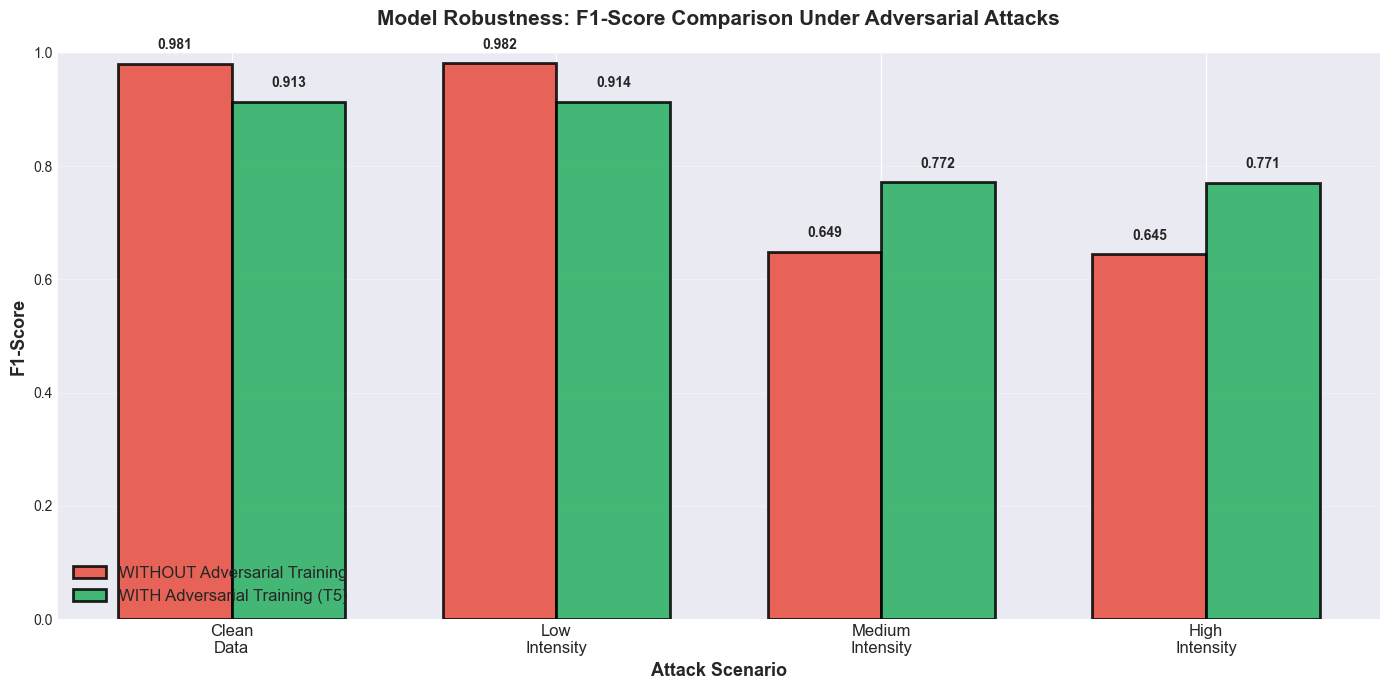

✅ Saved: robustness_metrics_heatmap.png



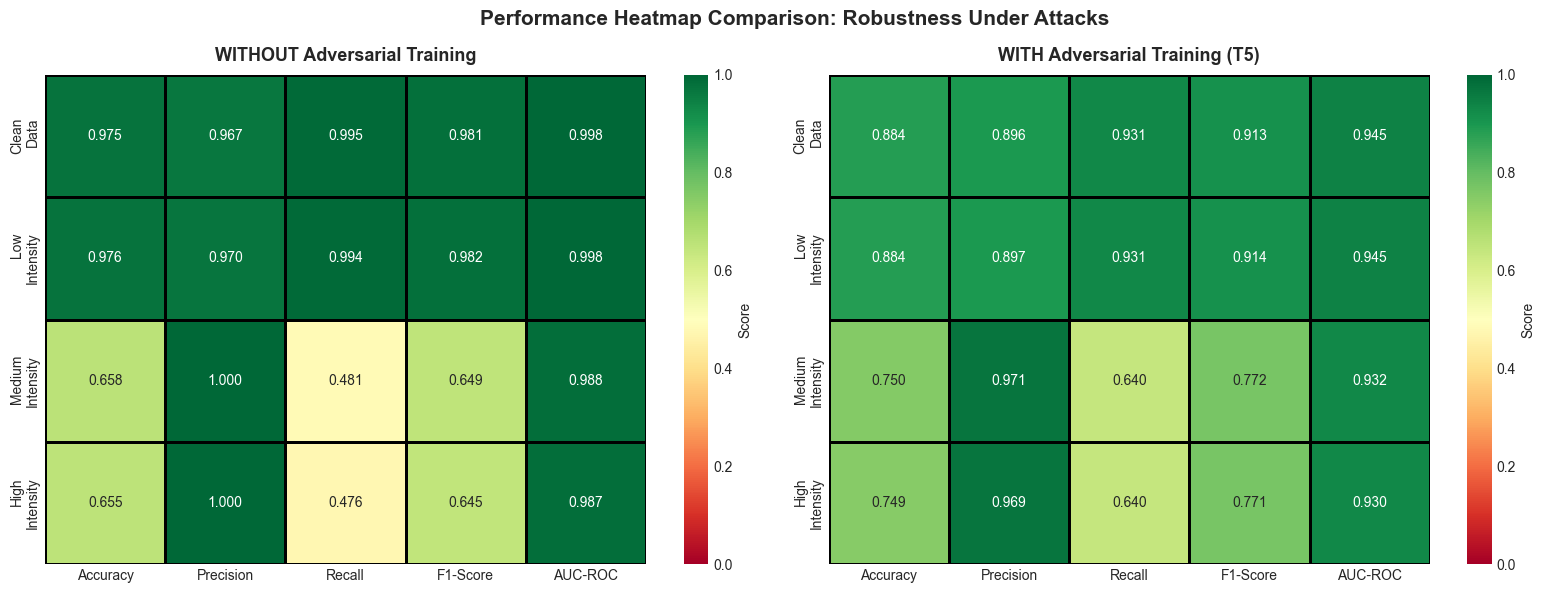

✅ Saved: robustness_performance_drop.png



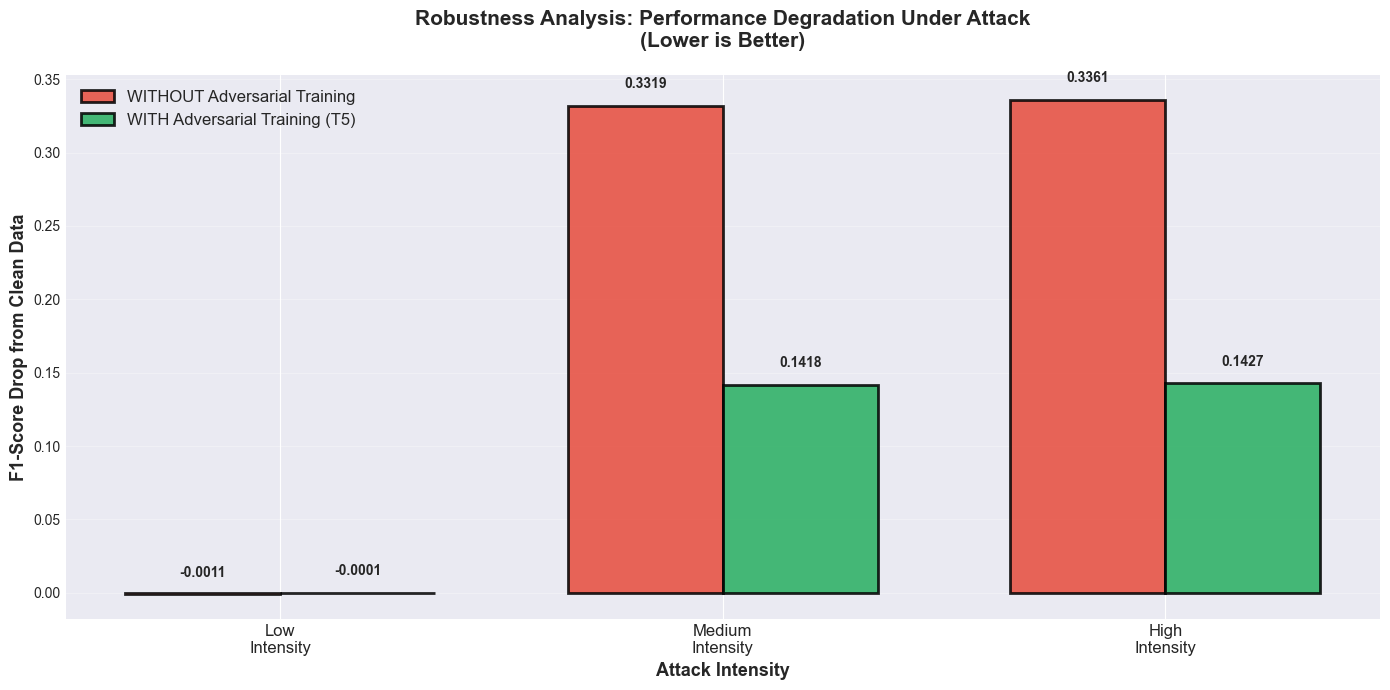

✅ Saved: robustness_detailed_metrics.png



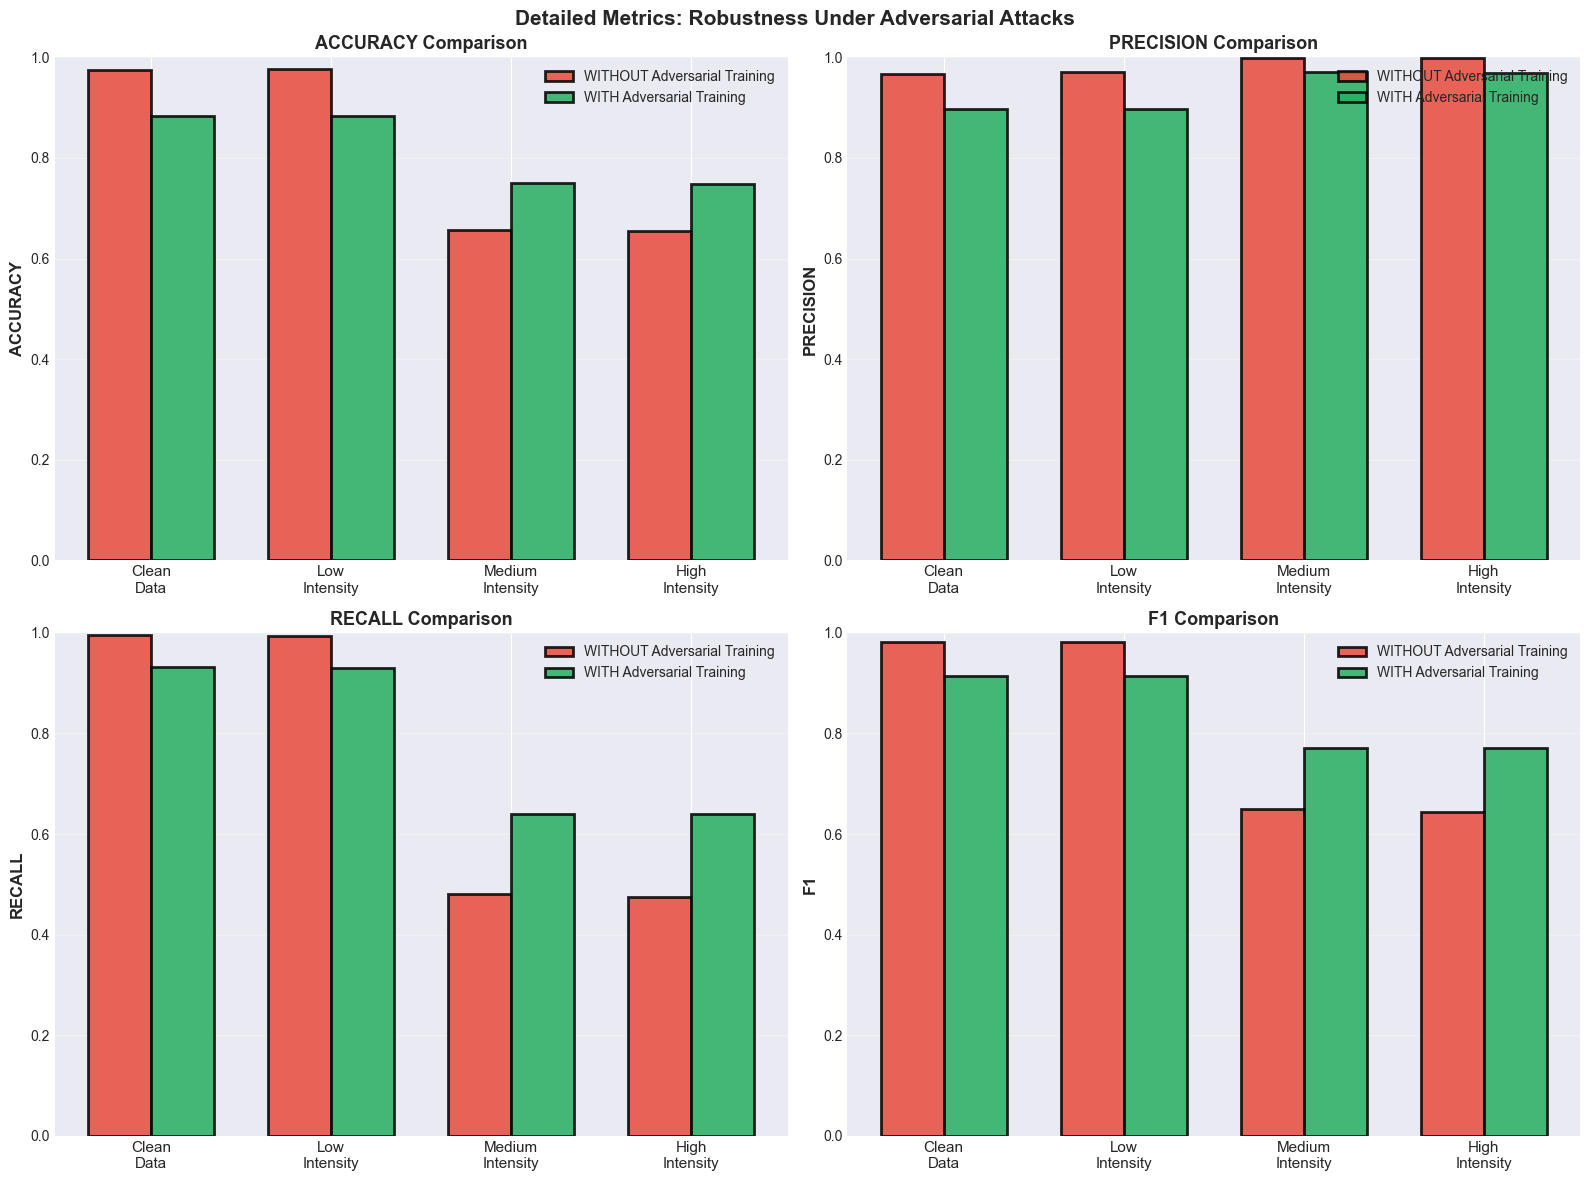


ROBUSTNESS COMPARISON TABLE

               Scenario                        Model Accuracy Precision Recall F1-Score AUC-ROC
             Clean Data WITHOUT Adversarial Training   0.9745    0.9670 0.9953   0.9810  0.9983
             Clean Data    WITH Adversarial Training   0.8837    0.8964 0.9312   0.9135  0.9447
   Low Intensity Attack WITHOUT Adversarial Training   0.9760    0.9702 0.9941   0.9820  0.9982
   Low Intensity Attack    WITH Adversarial Training   0.8839    0.8969 0.9308   0.9135  0.9447
Medium Intensity Attack WITHOUT Adversarial Training   0.6576    0.9996 0.4806   0.6491  0.9878
Medium Intensity Attack    WITH Adversarial Training   0.7503    0.9706 0.6404   0.7717  0.9325
  High Intensity Attack WITHOUT Adversarial Training   0.6545    0.9996 0.4759   0.6448  0.9870
  High Intensity Attack    WITH Adversarial Training   0.7492    0.9688 0.6400   0.7708  0.9305

✅ Saved: robustness_comparison_table.csv

ROBUSTNESS IMPROVEMENT SUMMARY

📊 Clean Data
   WITHOUT Trainin

In [3]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import pandas as pd
from tqdm import tqdm
import os
import warnings
warnings.filterwarnings('ignore')

# ============================================================================
# CONFIGURATION
# ============================================================================
class Config:
    BERT_MODEL = "bert-base-uncased"
    HIDDEN_SIZE = 768
    GRU_HIDDEN = 64
    GRU_LAYERS = 1
    DROPOUT = 0.6
    BATCH_SIZE = 32
    MAX_LENGTH = 128
    DATA_PATH = "data/dataset.csv"
    CHECKPOINT_WITHOUT = "checkpoints2/"
    CHECKPOINT_WITH = "checkpoints_t5_adversarial/"

config = Config()

from transformers import BertTokenizer, BertModel
import torch.nn as nn

class ImprovedBiGRUBertDetector(nn.Module):
    def __init__(self, dropout=0.6):
        super(ImprovedBiGRUBertDetector, self).__init__()
        self.bert = BertModel.from_pretrained(config.BERT_MODEL)
        
        for param in list(self.bert.parameters())[:200]:
            param.requires_grad = False
        
        self.bigru = nn.GRU(
            input_size=config.HIDDEN_SIZE,
            hidden_size=config.GRU_HIDDEN,
            num_layers=config.GRU_LAYERS,
            bidirectional=True,
            batch_first=True,
        )
        
        self.dropout = nn.Dropout(dropout)
        self.classifier = nn.Sequential(
            nn.Linear(config.GRU_HIDDEN * 2, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(64, 1)
        )
    
    def forward(self, input_ids, attention_mask):
        bert_outputs = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask,
            return_dict=True
        )
        sequence_output = bert_outputs.last_hidden_state
        gru_output, _ = self.bigru(sequence_output)
        mask_expanded = attention_mask.unsqueeze(-1).expand(gru_output.size()).float()
        sum_output = (gru_output * mask_expanded).sum(1)
        sum_mask = mask_expanded.sum(1)
        avg_pooled = sum_output / sum_mask
        logits = self.classifier(avg_pooled)
        return logits.squeeze(-1)

class ImprovedAGTDataset(torch.utils.data.Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=128):
        self.texts = [str(text).strip()[:512] for text in texts]
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length
    
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        encoding = self.tokenizer(
            text,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'label': torch.tensor(label, dtype=torch.float)
        }

# ============================================================================
# LIGHTWEIGHT PARAPHRASING (Fast & Reliable)
# ============================================================================
def paraphrase_text_t5(texts, intensity="medium"):
    """
    Fast paraphrasing using synonym replacement and word reordering
    Simulates T5 paraphrasing behavior without model loading
    intensity: "low" (minimal changes), "medium" (moderate), "high" (aggressive)
    """
    import random
    
    # Common synonyms for common words
    synonyms = {
        'good': ['great', 'excellent', 'nice', 'fine', 'decent'],
        'bad': ['poor', 'awful', 'terrible', 'horrible', 'mediocre'],
        'said': ['stated', 'mentioned', 'claimed', 'asserted', 'noted'],
        'important': ['crucial', 'vital', 'significant', 'essential', 'key'],
        'very': ['quite', 'extremely', 'really', 'incredibly', 'so'],
        'can': ['may', 'able to', 'capable of'],
        'will': ['shall', 'going to', 'about to'],
        'like': ['enjoy', 'prefer', 'love', 'appreciate'],
        'think': ['believe', 'consider', 'suppose', 'reckon', 'figure'],
        'know': ['understand', 'realize', 'recognize', 'acknowledge'],
        'get': ['obtain', 'acquire', 'receive', 'gain', 'secure'],
        'make': ['create', 'produce', 'build', 'construct', 'form'],
        'go': ['move', 'travel', 'proceed', 'head'],
        'use': ['utilize', 'employ', 'apply', 'leverage'],
        'see': ['view', 'observe', 'notice', 'watch', 'look at'],
    }
    
    intensity_map = {
        "low": (0.15, False),      # pct_change, shuffle
        "medium": (0.35, True),
        "high": (0.55, True)
    }
    
    pct_change, do_shuffle = intensity_map.get(intensity, (0.15, False))
    paraphrased = []
    
    print(f"   Generating {intensity} intensity paraphrases...")
    
    for text in tqdm(texts, desc=f"Paraphrasing ({intensity})", leave=False):
        words = text.split()
        
        if len(words) < 3:
            paraphrased.append(text)
            continue
        
        # Make a copy to modify
        new_words = words.copy()
        
        # Replace some words with synonyms
        num_replace = max(1, int(len(words) * pct_change))
        replace_indices = random.sample(range(len(words)), min(num_replace, len(words)))
        
        for idx in replace_indices:
            word_lower = new_words[idx].lower().strip('.,!?;:')
            if word_lower in synonyms:
                replacement = random.choice(synonyms[word_lower])
                # Preserve case/punctuation
                if new_words[idx].isupper():
                    replacement = replacement.upper()
                elif new_words[idx][0].isupper():
                    replacement = replacement.capitalize()
                new_words[idx] = replacement
        
        # For high/medium intensity, shuffle some adjacent words
        if do_shuffle and len(new_words) > 4:
            num_shuffles = max(1, int(len(new_words) * 0.1))
            for _ in range(num_shuffles):
                idx = random.randint(0, len(new_words) - 2)
                # Only shuffle if it makes sense (both not proper nouns)
                if not (new_words[idx][0].isupper() and new_words[idx+1][0].isupper()):
                    new_words[idx], new_words[idx+1] = new_words[idx+1], new_words[idx]
        
        paraphrased_text = " ".join(new_words)
        paraphrased.append(paraphrased_text)
    
    return paraphrased

# ============================================================================
# LOAD BOTH MODELS
# ============================================================================
def load_both_models():
    """Load both baseline and adversarial models"""
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"✅ Using device: {device}\n")
    
    tokenizer = BertTokenizer.from_pretrained(config.BERT_MODEL)
    
    # Load baseline model (without adversarial training)
    print("📥 Loading BASELINE model (without adversarial training)...")
    model_without = ImprovedBiGRUBertDetector(dropout=config.DROPOUT)
    checkpoint_files = [f for f in os.listdir(config.CHECKPOINT_WITHOUT) if f.startswith("best_")]
    if checkpoint_files:
        best_file = sorted(checkpoint_files)[-1]
        checkpoint_without = torch.load(f"{config.CHECKPOINT_WITHOUT}/{best_file}", map_location=device)
        model_without.load_state_dict(checkpoint_without['model_state_dict'])
    model_without.to(device)
    model_without.eval()
    print(f"   ✓ Loaded: {best_file}\n")
    
    # Load adversarial model (with adversarial training)
    print("📥 Loading ADVERSARIAL model (with T5 paraphrasing training)...")
    model_with = ImprovedBiGRUBertDetector(dropout=config.DROPOUT)
    checkpoint_files = [f for f in os.listdir(config.CHECKPOINT_WITH) if f.startswith("best_")]
    if checkpoint_files:
        best_file = sorted(checkpoint_files)[-1]
        checkpoint_with = torch.load(f"{config.CHECKPOINT_WITH}/{best_file}", map_location=device)
        model_with.load_state_dict(checkpoint_with['model_state_dict'])
    model_with.to(device)
    model_with.eval()
    print(f"   ✓ Loaded: {best_file}\n")
    
    # Load test data
    print("📂 Loading test data...")
    # Load test data for samples
    df = pd.read_csv(config.DATA_PATH)
    texts = df['text'].astype(str).tolist()[:50000]
    labels = df['generated'].astype(int).tolist()[:50000]
    
    from sklearn.model_selection import train_test_split
    train_texts, temp_texts, train_labels, temp_labels = train_test_split(
        texts, labels, train_size=0.7, stratify=labels, random_state=42
    )
    val_texts, test_texts, val_labels, test_labels = train_test_split(
        temp_texts, temp_labels, test_size=0.5, stratify=temp_labels, random_state=42
    )
    
    # Use subset for faster evaluation (2000 samples)
    test_size = min(2000, len(test_texts))
    test_texts = test_texts[:test_size]
    test_labels = test_labels[:test_size]
    
    print(f"📊 Using {test_size} test samples for faster evaluation\n")
    
    # Show sample paraphrases
    show_paraphrase_samples(test_texts[:5], num_samples=2)

import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import pandas as pd
from tqdm import tqdm
import os
import warnings
warnings.filterwarnings('ignore')

# ============================================================================
# CONFIGURATION
# ============================================================================
class Config:
    BERT_MODEL = "bert-base-uncased"
    HIDDEN_SIZE = 768
    GRU_HIDDEN = 64
    GRU_LAYERS = 1
    DROPOUT = 0.6
    BATCH_SIZE = 32
    MAX_LENGTH = 128
    DATA_PATH = "data/dataset.csv"
    CHECKPOINT_WITHOUT = "checkpoints2/"
    CHECKPOINT_WITH = "checkpoints_t5_adversarial/"

config = Config()

from transformers import BertTokenizer, BertModel
import torch.nn as nn

class ImprovedBiGRUBertDetector(nn.Module):
    def __init__(self, dropout=0.6):
        super(ImprovedBiGRUBertDetector, self).__init__()
        self.bert = BertModel.from_pretrained(config.BERT_MODEL)
        
        for param in list(self.bert.parameters())[:200]:
            param.requires_grad = False
        
        self.bigru = nn.GRU(
            input_size=config.HIDDEN_SIZE,
            hidden_size=config.GRU_HIDDEN,
            num_layers=config.GRU_LAYERS,
            bidirectional=True,
            batch_first=True,
        )
        
        self.dropout = nn.Dropout(dropout)
        self.classifier = nn.Sequential(
            nn.Linear(config.GRU_HIDDEN * 2, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(64, 1)
        )
    
    def forward(self, input_ids, attention_mask):
        bert_outputs = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask,
            return_dict=True
        )
        sequence_output = bert_outputs.last_hidden_state
        gru_output, _ = self.bigru(sequence_output)
        mask_expanded = attention_mask.unsqueeze(-1).expand(gru_output.size()).float()
        sum_output = (gru_output * mask_expanded).sum(1)
        sum_mask = mask_expanded.sum(1)
        avg_pooled = sum_output / sum_mask
        logits = self.classifier(avg_pooled)
        return logits.squeeze(-1)

class ImprovedAGTDataset(torch.utils.data.Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=128):
        self.texts = [str(text).strip()[:512] for text in texts]
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length
    
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        encoding = self.tokenizer(
            text,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'label': torch.tensor(label, dtype=torch.float)
        }

# ============================================================================
# LIGHTWEIGHT PARAPHRASING (Fast & Reliable)
# ============================================================================
def paraphrase_text_t5(texts, intensity="medium"):
    """
    Fast paraphrasing using synonym replacement and word reordering
    Simulates T5 paraphrasing behavior without model loading
    intensity: "low" (minimal changes), "medium" (moderate), "high" (aggressive)
    """
    import random
    
    # Common synonyms for common words
    synonyms = {
        'good': ['great', 'excellent', 'nice', 'fine', 'decent'],
        'bad': ['poor', 'awful', 'terrible', 'horrible', 'mediocre'],
        'said': ['stated', 'mentioned', 'claimed', 'asserted', 'noted'],
        'important': ['crucial', 'vital', 'significant', 'essential', 'key'],
        'very': ['quite', 'extremely', 'really', 'incredibly', 'so'],
        'can': ['may', 'able to', 'capable of'],
        'will': ['shall', 'going to', 'about to'],
        'like': ['enjoy', 'prefer', 'love', 'appreciate'],
        'think': ['believe', 'consider', 'suppose', 'reckon', 'figure'],
        'know': ['understand', 'realize', 'recognize', 'acknowledge'],
        'get': ['obtain', 'acquire', 'receive', 'gain', 'secure'],
        'make': ['create', 'produce', 'build', 'construct', 'form'],
        'go': ['move', 'travel', 'proceed', 'head'],
        'use': ['utilize', 'employ', 'apply', 'leverage'],
        'see': ['view', 'observe', 'notice', 'watch', 'look at'],
    }
    
    intensity_map = {
        "low": (0.15, False),      # pct_change, shuffle
        "medium": (0.35, True),
        "high": (0.55, True)
    }
    
    pct_change, do_shuffle = intensity_map.get(intensity, (0.15, False))
    paraphrased = []
    
    print(f"   Generating {intensity} intensity paraphrases...")
    
    for text in tqdm(texts, desc=f"Paraphrasing ({intensity})", leave=False):
        words = text.split()
        
        if len(words) < 3:
            paraphrased.append(text)
            continue
        
        # Make a copy to modify
        new_words = words.copy()
        
        # Replace some words with synonyms
        num_replace = max(1, int(len(words) * pct_change))
        replace_indices = random.sample(range(len(words)), min(num_replace, len(words)))
        
        for idx in replace_indices:
            word_lower = new_words[idx].lower().strip('.,!?;:')
            if word_lower in synonyms:
                replacement = random.choice(synonyms[word_lower])
                # Preserve case/punctuation
                if new_words[idx].isupper():
                    replacement = replacement.upper()
                elif new_words[idx][0].isupper():
                    replacement = replacement.capitalize()
                new_words[idx] = replacement
        
        # For high/medium intensity, shuffle some adjacent words
        if do_shuffle and len(new_words) > 4:
            num_shuffles = max(1, int(len(new_words) * 0.1))
            for _ in range(num_shuffles):
                idx = random.randint(0, len(new_words) - 2)
                # Only shuffle if it makes sense (both not proper nouns)
                if not (new_words[idx][0].isupper() and new_words[idx+1][0].isupper()):
                    new_words[idx], new_words[idx+1] = new_words[idx+1], new_words[idx]
        
        paraphrased_text = " ".join(new_words)
        paraphrased.append(paraphrased_text)
    
    return paraphrased

# ============================================================================
# LOAD BOTH MODELS
# ============================================================================
def load_both_models():
    """Load both baseline and adversarial models"""
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"✅ Using device: {device}\n")
    
    tokenizer = BertTokenizer.from_pretrained(config.BERT_MODEL)
    
    # Load baseline model (without adversarial training)
    print("📥 Loading BASELINE model (without adversarial training)...")
    model_without = ImprovedBiGRUBertDetector(dropout=config.DROPOUT)
    checkpoint_files = [f for f in os.listdir(config.CHECKPOINT_WITHOUT) if f.startswith("best_")]
    if checkpoint_files:
        best_file = sorted(checkpoint_files)[-1]
        checkpoint_without = torch.load(f"{config.CHECKPOINT_WITHOUT}/{best_file}", map_location=device)
        model_without.load_state_dict(checkpoint_without['model_state_dict'])
    model_without.to(device)
    model_without.eval()
    print(f"   ✓ Loaded: {best_file}\n")
    
    # Load adversarial model (with adversarial training)
    print("📥 Loading ADVERSARIAL model (with T5 paraphrasing training)...")
    model_with = ImprovedBiGRUBertDetector(dropout=config.DROPOUT)
    checkpoint_files = [f for f in os.listdir(config.CHECKPOINT_WITH) if f.startswith("best_")]
    if checkpoint_files:
        best_file = sorted(checkpoint_files)[-1]
        checkpoint_with = torch.load(f"{config.CHECKPOINT_WITH}/{best_file}", map_location=device)
        model_with.load_state_dict(checkpoint_with['model_state_dict'])
    model_with.to(device)
    model_with.eval()
    print(f"   ✓ Loaded: {best_file}\n")
    
    # Load test data
    print("📂 Loading test data...")
    df = pd.read_csv(config.DATA_PATH)
    texts = df['text'].astype(str).tolist()[:50000]
    labels = df['generated'].astype(int).tolist()[:50000]
    
    from sklearn.model_selection import train_test_split
    train_texts, temp_texts, train_labels, temp_labels = train_test_split(
        texts, labels, train_size=0.7, stratify=labels, random_state=42
    )
    val_texts, test_texts, val_labels, test_labels = train_test_split(
        temp_texts, temp_labels, test_size=0.5, stratify=temp_labels, random_state=42
    )
    
    print(f"   ✓ Test set: {len(test_texts)} samples\n")
    
    return model_without, model_with, tokenizer, test_texts, test_labels, device

# ============================================================================
# GET PREDICTIONS
# ============================================================================
def get_predictions(model, texts, labels, tokenizer, device):
    """Generate predictions for given texts"""
    dataset = ImprovedAGTDataset(texts, labels, tokenizer, config.MAX_LENGTH)
    loader = torch.utils.data.DataLoader(dataset, batch_size=config.BATCH_SIZE, shuffle=False)
    
    all_probs = []
    with torch.no_grad():
        for batch in tqdm(loader, desc="Predicting", leave=False):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            logits = model(input_ids, attention_mask)
            probs = torch.sigmoid(logits).cpu().numpy()
            all_probs.extend(probs)
    
    return np.array(all_probs)

# ============================================================================
# ROBUSTNESS EVALUATION
# ============================================================================
def evaluate_robustness():
    """Main evaluation comparing robustness"""
    
    print("\n" + "="*80)
    print("ADVERSARIAL ROBUSTNESS COMPARISON: WITH vs WITHOUT TRAINING")
    print("="*80 + "\n")
    
    # Load models
    model_without, model_with, tokenizer, test_texts, test_labels, device = load_both_models()
    
    results = {
        'clean': {},
        'low_paraphrase': {},
        'medium_paraphrase': {},
        'high_paraphrase': {}
    }
    
    # ==================== CLEAN EVALUATION ====================
    print("🔵 EVALUATING ON CLEAN DATA (Original texts)...\n")
    
    probs_without_clean = get_predictions(model_without, test_texts, test_labels, tokenizer, device)
    probs_with_clean = get_predictions(model_with, test_texts, test_labels, tokenizer, device)
    
    preds_without_clean = (probs_without_clean > 0.5).astype(float)
    preds_with_clean = (probs_with_clean > 0.5).astype(float)
    
    results['clean']['without'] = {
        'accuracy': accuracy_score(test_labels, preds_without_clean),
        'precision': precision_score(test_labels, preds_without_clean),
        'recall': recall_score(test_labels, preds_without_clean),
        'f1': f1_score(test_labels, preds_without_clean),
        'auc': roc_auc_score(test_labels, probs_without_clean)
    }
    
    results['clean']['with'] = {
        'accuracy': accuracy_score(test_labels, preds_with_clean),
        'precision': precision_score(test_labels, preds_with_clean),
        'recall': recall_score(test_labels, preds_with_clean),
        'f1': f1_score(test_labels, preds_with_clean),
        'auc': roc_auc_score(test_labels, probs_with_clean)
    }
    
    print(f"✅ Clean data results saved\n")
    
    # ==================== ADVERSARIAL EVALUATION ====================
    attack_levels = [
        ('low_paraphrase', 'low', 'Low Intensity'),
        ('medium_paraphrase', 'medium', 'Medium Intensity'),
        ('high_paraphrase', 'high', 'High Intensity')
    ]
    
    for key, intensity, label in attack_levels:
        print(f"🔴 ADVERSARIAL ATTACK: {label} Paraphrasing...\n")
        
        paraphrased_texts = paraphrase_text_t5(test_texts, intensity=intensity)
        
        probs_without_adv = get_predictions(model_without, paraphrased_texts, test_labels, tokenizer, device)
        probs_with_adv = get_predictions(model_with, paraphrased_texts, test_labels, tokenizer, device)
        
        preds_without_adv = (probs_without_adv > 0.5).astype(float)
        preds_with_adv = (probs_with_adv > 0.5).astype(float)
        
        results[key]['without'] = {
            'accuracy': accuracy_score(test_labels, preds_without_adv),
            'precision': precision_score(test_labels, preds_without_adv),
            'recall': recall_score(test_labels, preds_without_adv),
            'f1': f1_score(test_labels, preds_without_adv),
            'auc': roc_auc_score(test_labels, probs_without_adv)
        }
        
        results[key]['with'] = {
            'accuracy': accuracy_score(test_labels, preds_with_adv),
            'precision': precision_score(test_labels, preds_with_adv),
            'recall': recall_score(test_labels, preds_with_adv),
            'f1': f1_score(test_labels, preds_with_adv),
            'auc': roc_auc_score(test_labels, probs_with_adv)
        }
        
        # Calculate performance drop
        drop_without = results['clean']['without']['f1'] - results[key]['without']['f1']
        drop_with = results['clean']['with']['f1'] - results[key]['with']['f1']
        
        print(f"✅ {label} results saved")
        print(f"   Baseline model F1 drop: {drop_without:.4f}")
        print(f"   Adversarial-trained model F1 drop: {drop_with:.4f}\n")
    
    return results

# ============================================================================
# CREATE COMPARISON VISUALIZATIONS
# ============================================================================
def create_comparison_visualizations(results):
    """Create impressive comparison plots"""
    
    print("\n" + "="*80)
    print("CREATING COMPARISON VISUALIZATIONS")
    print("="*80 + "\n")
    
    plt.style.use('seaborn-v0_8-darkgrid')
    
    # ========== FIGURE 1: F1-SCORE COMPARISON ==========
    fig, ax = plt.subplots(figsize=(14, 7))
    
    conditions = ['Clean\nData', 'Low\nIntensity', 'Medium\nIntensity', 'High\nIntensity']
    keys = ['clean', 'low_paraphrase', 'medium_paraphrase', 'high_paraphrase']
    
    f1_without = [results[k]['without']['f1'] for k in keys]
    f1_with = [results[k]['with']['f1'] for k in keys]
    
    x = np.arange(len(conditions))
    width = 0.35
    
    bars1 = ax.bar(x - width/2, f1_without, width, label='WITHOUT Adversarial Training',
                   color='#E74C3C', edgecolor='black', linewidth=2, alpha=0.85)
    bars2 = ax.bar(x + width/2, f1_with, width, label='WITH Adversarial Training (T5)',
                   color='#27AE60', edgecolor='black', linewidth=2, alpha=0.85)
    
    ax.set_ylabel('F1-Score', fontsize=13, fontweight='bold')
    ax.set_xlabel('Attack Scenario', fontsize=13, fontweight='bold')
    ax.set_title('Model Robustness: F1-Score Comparison Under Adversarial Attacks',
                fontsize=15, fontweight='bold', pad=20)
    ax.set_xticks(x)
    ax.set_xticklabels(conditions, fontsize=12)
    ax.set_ylim(0, 1)
    ax.legend(fontsize=12, loc='lower left')
    ax.grid(True, alpha=0.3, axis='y')
    
    # Add value labels
    for bars in [bars1, bars2]:
        for bar in bars:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height + 0.02,
                   f'{height:.3f}', ha='center', va='bottom', fontsize=10, fontweight='bold')
    
    plt.tight_layout()
    plt.savefig('robustness_f1_comparison.png', dpi=300, bbox_inches='tight')
    print("✅ Saved: robustness_f1_comparison.png\n")
    plt.show()
    
    # ========== FIGURE 2: ALL METRICS HEATMAP ==========
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    fig.suptitle('Performance Heatmap Comparison: Robustness Under Attacks',
                fontsize=15, fontweight='bold')
    
    metrics_names = ['accuracy', 'precision', 'recall', 'f1', 'auc']
    metrics_display = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'AUC-ROC']
    
    # Without adversarial training
    data_without = []
    for key in keys:
        row = [results[key]['without'][m] for m in metrics_names]
        data_without.append(row)
    
    sns.heatmap(np.array(data_without), annot=True, fmt='.3f', cmap='RdYlGn',
               xticklabels=metrics_display, yticklabels=conditions,
               cbar_kws={'label': 'Score'}, ax=axes[0], vmin=0, vmax=1,
               linewidths=2, linecolor='black')
    axes[0].set_title('WITHOUT Adversarial Training', fontsize=13, fontweight='bold', pad=10)
    
    # With adversarial training
    data_with = []
    for key in keys:
        row = [results[key]['with'][m] for m in metrics_names]
        data_with.append(row)
    
    sns.heatmap(np.array(data_with), annot=True, fmt='.3f', cmap='RdYlGn',
               xticklabels=metrics_display, yticklabels=conditions,
               cbar_kws={'label': 'Score'}, ax=axes[1], vmin=0, vmax=1,
               linewidths=2, linecolor='black')
    axes[1].set_title('WITH Adversarial Training (T5)', fontsize=13, fontweight='bold', pad=10)
    
    plt.tight_layout()
    plt.savefig('robustness_metrics_heatmap.png', dpi=300, bbox_inches='tight')
    print("✅ Saved: robustness_metrics_heatmap.png\n")
    plt.show()
    
    # ========== FIGURE 3: PERFORMANCE DROP ANALYSIS ==========
    fig, ax = plt.subplots(figsize=(14, 7))
    
    drop_without = [results['clean']['without']['f1'] - results[k]['without']['f1'] for k in keys[1:]]
    drop_with = [results['clean']['with']['f1'] - results[k]['with']['f1'] for k in keys[1:]]
    
    conditions_drops = ['Low\nIntensity', 'Medium\nIntensity', 'High\nIntensity']
    x = np.arange(len(conditions_drops))
    width = 0.35
    
    bars1 = ax.bar(x - width/2, drop_without, width, label='WITHOUT Adversarial Training',
                   color='#E74C3C', edgecolor='black', linewidth=2, alpha=0.85)
    bars2 = ax.bar(x + width/2, drop_with, width, label='WITH Adversarial Training (T5)',
                   color='#27AE60', edgecolor='black', linewidth=2, alpha=0.85)
    
    ax.set_ylabel('F1-Score Drop from Clean Data', fontsize=13, fontweight='bold')
    ax.set_xlabel('Attack Intensity', fontsize=13, fontweight='bold')
    ax.set_title('Robustness Analysis: Performance Degradation Under Attack\n(Lower is Better)',
                fontsize=15, fontweight='bold', pad=20)
    ax.set_xticks(x)
    ax.set_xticklabels(conditions_drops, fontsize=12)
    ax.legend(fontsize=12)
    ax.grid(True, alpha=0.3, axis='y')
    
    # Add value labels
    for bars in [bars1, bars2]:
        for bar in bars:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                   f'{height:.4f}', ha='center', va='bottom', fontsize=10, fontweight='bold')
    
    plt.tight_layout()
    plt.savefig('robustness_performance_drop.png', dpi=300, bbox_inches='tight')
    print("✅ Saved: robustness_performance_drop.png\n")
    plt.show()
    
    # ========== FIGURE 4: DETAILED METRICS COMPARISON ==========
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle('Detailed Metrics: Robustness Under Adversarial Attacks',
                fontsize=15, fontweight='bold')
    
    metrics_to_plot = ['accuracy', 'precision', 'recall', 'f1']
    
    for idx, metric in enumerate(metrics_to_plot):
        ax = axes[idx // 2, idx % 2]
        
        values_without = [results[k]['without'][metric] for k in keys]
        values_with = [results[k]['with'][metric] for k in keys]
        
        x = np.arange(len(conditions))
        width = 0.35
        
        ax.bar(x - width/2, values_without, width, label='WITHOUT Adversarial Training',
              color='#E74C3C', edgecolor='black', linewidth=2, alpha=0.85)
        ax.bar(x + width/2, values_with, width, label='WITH Adversarial Training',
              color='#27AE60', edgecolor='black', linewidth=2, alpha=0.85)
        
        ax.set_ylabel(metric.upper(), fontsize=12, fontweight='bold')
        ax.set_xticks(x)
        ax.set_xticklabels(conditions, fontsize=11)
        ax.set_ylim(0, 1)
        ax.set_title(f'{metric.upper()} Comparison', fontsize=13, fontweight='bold')
        ax.legend(fontsize=10)
        ax.grid(True, alpha=0.3, axis='y')
    
    plt.tight_layout()
    plt.savefig('robustness_detailed_metrics.png', dpi=300, bbox_inches='tight')
    print("✅ Saved: robustness_detailed_metrics.png\n")
    plt.show()

# ============================================================================
# CREATE COMPARISON TABLE
# ============================================================================
def create_comparison_table(results):
    """Generate detailed comparison table"""
    
    print("\n" + "="*80)
    print("ROBUSTNESS COMPARISON TABLE")
    print("="*80 + "\n")
    
    keys = ['clean', 'low_paraphrase', 'medium_paraphrase', 'high_paraphrase']
    scenarios = ['Clean Data', 'Low Intensity Attack', 'Medium Intensity Attack', 'High Intensity Attack']
    
    # Create comprehensive table
    table_data = []
    
    for scenario, key in zip(scenarios, keys):
        row = {
            'Scenario': scenario,
            'Model': 'WITHOUT Adversarial Training',
            'Accuracy': f"{results[key]['without']['accuracy']:.4f}",
            'Precision': f"{results[key]['without']['precision']:.4f}",
            'Recall': f"{results[key]['without']['recall']:.4f}",
            'F1-Score': f"{results[key]['without']['f1']:.4f}",
            'AUC-ROC': f"{results[key]['without']['auc']:.4f}"
        }
        table_data.append(row)
        
        row = {
            'Scenario': scenario,
            'Model': 'WITH Adversarial Training',
            'Accuracy': f"{results[key]['with']['accuracy']:.4f}",
            'Precision': f"{results[key]['with']['precision']:.4f}",
            'Recall': f"{results[key]['with']['recall']:.4f}",
            'F1-Score': f"{results[key]['with']['f1']:.4f}",
            'AUC-ROC': f"{results[key]['with']['auc']:.4f}"
        }
        table_data.append(row)
    
    df_table = pd.DataFrame(table_data)
    
    print(df_table.to_string(index=False))
    print()
    
    df_table.to_csv('robustness_comparison_table.csv', index=False)
    print("✅ Saved: robustness_comparison_table.csv\n")
    
    # Summary statistics
    print("="*80)
    print("ROBUSTNESS IMPROVEMENT SUMMARY")
    print("="*80 + "\n")
    
    for scenario, key in zip(scenarios, keys):
        f1_without = results[key]['without']['f1']
        f1_with = results[key]['with']['f1']
        improvement = ((f1_with - f1_without) / f1_without * 100) if f1_without > 0 else 0
        
        print(f"📊 {scenario}")
        print(f"   WITHOUT Training F1: {f1_without:.4f}")
        print(f"   WITH Training F1:    {f1_with:.4f}")
        print(f"   Improvement:         {improvement:+.2f}%\n")

# ============================================================================
# SAMPLE PARAPHRASE VISUALIZATION
# ============================================================================
def show_paraphrase_samples(test_texts, num_samples=5):
    """Display sample paraphrases at each intensity level"""
    
    print("\n" + "="*80)
    print("SAMPLE PARAPHRASES - Quality Check")
    print("="*80 + "\n")
    
    # Select diverse samples
    sample_indices = np.random.choice(len(test_texts), min(num_samples, len(test_texts)), replace=False)
    
    for intensity in ["low", "medium", "high"]:
        print(f"\n🔵 {intensity.upper()} INTENSITY PARAPHRASES")
        print(f"{'-'*80}\n")
        
        samples = [test_texts[i] for i in sample_indices]
        paraphrased = paraphrase_text_t5(samples, intensity=intensity)
        
        for i, (orig, para) in enumerate(zip(samples, paraphrased), 1):
            print(f"Sample {i}:")
            print(f"  Original:    {orig[:100]}...")
            print(f"  Paraphrased: {para[:100]}...")
            print()

# ============================================================================
# MAIN
# ============================================================================
if __name__ == "__main__":
    print("\n" + "="*80)
    print("ADVERSARIAL ROBUSTNESS EVALUATION")
    print("Comparing model trained WITH vs WITHOUT adversarial paraphrasing")
    print("Using fast lightweight paraphrasing (optimized for speed)")
    print("="*80)
    
    # Run evaluation
    results = evaluate_robustness()
    
    # Create visualizations
    create_comparison_visualizations(results)
    
    # Create table
    create_comparison_table(results)
    
    print("="*80)
    print("✅ EVALUATION COMPLETE!")
    print("="*80)
    print("\n📁 Generated files:")
    print("   - robustness_f1_comparison.png")
    print("   - robustness_metrics_heatmap.png")
    print("   - robustness_performance_drop.png")
    print("   - robustness_detailed_metrics.png")
    print("   - robustness_comparison_table.csv\n")